In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares
from sklearn.base import BaseEstimator, RegressorMixin
import pingouin as pg
import seaborn as sns

plt.rcParams['xtick.bottom'] = True  # Show ticks at the bottom of the x-axis
plt.rcParams['xtick.top'] = True     # Show ticks at the top of the x-axis
plt.rcParams['ytick.left'] = True    # Show ticks on the left side of the y-axis
plt.rcParams['ytick.right'] = True   # Show ticks on the right side of the y-axis


plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5

class PsychometricFit(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.slope_ = None
        self.threshold_ = None
        self.popt_ = None
        self.r_squared_ = None

    def _sigmoid(self, x, x0, k, L=1, b=0):
        return L / (1 + np.exp(-k * (x - x0))) + b

    def _residuals(self, params, x, y):
        return y - self._sigmoid(x, *params)

    def fit(self, X, y):
        initial_guess = [np.median(X), 1.0, 1.0, 0.0]
        bounds = (
            [0, 0, 0, -1],
            [1, 500, 1, 1]
        )
        result = least_squares(self._residuals, initial_guess, bounds=bounds, args=(X, y))
        self.popt_ = result.x
        self.threshold_ = result.x[0]
        self.slope_ = result.x[1]

        residuals = y - self._sigmoid(X, *result.x)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        self.r_squared_ = 1 - (ss_res / ss_tot)
        return self

    def predict(self, X):
        return self._sigmoid(X, *self.popt_)

    @property
    def slope(self):
        return self.slope_

    @property
    def threshold(self):
        return self.threshold_

    @property
    def r_squared(self):
        return self.r_squared_

    def summary_dataframe(self):
        data = {
            'slope': [self.slope_],
            'threshold': [self.threshold_],
            'x0': [self.popt_[0]],
            'k': [self.popt_[1]],
            'L': [self.popt_[2]],
            'b': [self.popt_[3]],
            'r_squared': [self.r_squared_]
        }
        return pd.DataFrame(data)

intensities_real = np.array([0,50,150,300,500])
intensities_real_norm = intensities_real/500
ylims = dict(pupil=(-20,80),locom=(-60,350))


# Fig S1A

In [88]:
der_pupil = pd.read_excel('Data/fig_S1/DER_pupil_sex.xlsx')
male_der_pupil = der_pupil[der_pupil['sex']=='male']
female_der_pupil = der_pupil[der_pupil['sex']=='female']

female_der_pupil

,sub,intensity,pupil,sex
80,0,0,-0.358544,female
81,0,50,7.674984,female
82,0,150,13.353353,female
83,0,300,17.075959,female
84,0,500,16.512291,female
...,...,...,...,...
155,15,0,-0.499812,female
156,15,50,14.606140,female
157,15,150,44.306043,female
158,15,300,55.823210,female


C:\Users\pupil\AppData\Local\Temp\ipykernel_13576\3987913598.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  der_psize_curve_avg = female_der_pupil.groupby('intensity',axis=0).mean().reset_index()
C:\Users\pupil\AppData\Local\Temp\ipykernel_13576\3987913598.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  der_psize_curve_sem = female_der_pupil.groupby('intensity',axis=0).sem().reset_index()
C:\Users\pupil\AppData\Local\Temp\ipykernel_13576\3987913598.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. 

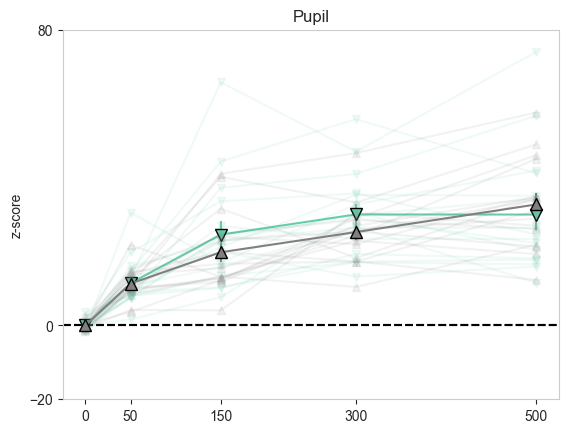

In [89]:
fig,ax = plt.subplots()

for su in female_der_pupil['sub'].unique():
    fem_temp_sub = female_der_pupil[female_der_pupil['sub']==su]
    ax.errorbar( fem_temp_sub['intensity'], fem_temp_sub['pupil'], color='#66CDAA', marker='v', markerfacecolor='#66CDAA', linestyle='-',markeredgecolor=None, alpha=.1 )
der_psize_curve_avg = female_der_pupil.groupby('intensity',axis=0).mean().reset_index()
der_psize_curve_sem = female_der_pupil.groupby('intensity',axis=0).sem().reset_index()
ax.errorbar( der_psize_curve_avg['intensity'], der_psize_curve_avg['pupil'], yerr=der_psize_curve_sem['pupil'], color='#66CDAA', marker='v', markerfacecolor='#66CDAA', linestyle='-',markeredgecolor='k', alpha=1, markersize=8 )
ax.axhline(y=0, color='k',linestyle='--')
ax.set_ylabel('z-score')
ax.set_title('Pupil')
#ax_pup_peaks.set_xlabel('Shock Intensity Level [uA]')
ax.grid(False)
ax.set_xticks(intensities_real)
#ax.set_xticklabels([])
ax.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
ax.set_yticks([ylims['pupil'][0],0,ylims['pupil'][1]])


for su in male_der_pupil['sub'].unique():
    mal_temp_sub = male_der_pupil[male_der_pupil['sub']==su]
    ax.errorbar( mal_temp_sub['intensity'], mal_temp_sub['pupil'], color='grey', marker='^', markerfacecolor='grey', linestyle='-',markeredgecolor=None, alpha=.1 )
der_psize_curve_avg = male_der_pupil.groupby('intensity',axis=0).mean().reset_index()
der_psize_curve_sem = male_der_pupil.groupby('intensity',axis=0).sem().reset_index()
ax.errorbar( der_psize_curve_avg['intensity'], der_psize_curve_avg['pupil'], yerr=der_psize_curve_sem['pupil'], color='grey', marker='^', markerfacecolor='grey', linestyle='-',markeredgecolor='k', alpha=1, markersize=8 )
ax.axhline(y=0, color='k',linestyle='--')
ax.set_ylabel('z-score')
ax.set_title('Pupil')
#ax_pup_peaks.set_xlabel('Shock Intensity Level [uA]')
ax.grid(False)
ax.set_xticks(intensities_real)
#ax.set_xticklabels([])
ax.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
ax.set_yticks([ylims['pupil'][0],0,ylims['pupil'][1]])

In [90]:
der_pupil['unique_id'] = der_pupil['sub'].apply(str)+ '_' + der_pupil['sex']
pg.mixed_anova(data=der_pupil,dv='pupil',within='intensity',between='sex',subject='unique_id').round(3)

C:\Users\pupil\.conda\envs\brain_\lib\site-packages\pingouin\parametric.py:1574: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,sex,76.670,1,30,76.670,0.324,0.573,NaN,0.011,NaN,NaN,NaN,NaN
1,intensity,20960.552,4,120,5240.138,77.034,0.000,0.0,0.720,0.602,False,0.246,0.0
2,Interaction,346.684,4,120,86.671,1.274,0.284,NaN,0.041,NaN,NaN,NaN,NaN


# Fig S1B

In [91]:
der_locom = pd.read_excel('Data/fig_S1/DER_locom_sex.xlsx')
male_der_locom = der_locom[der_locom['sex']=='male']
female_der_locom = der_locom[der_locom['sex']=='female']

female_der_locom

,sub,intensity,locomotor,sex
80,0,0,3.597902,female
81,0,50,34.273328,female
82,0,150,54.472342,female
83,0,300,59.088828,female
84,0,500,117.444571,female
...,...,...,...,...
155,15,0,1.744675,female
156,15,50,2.698635,female
157,15,150,7.738712,female
158,15,300,15.457354,female


C:\Users\pupil\AppData\Local\Temp\ipykernel_13576\3053474120.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  der_psize_curve_avg = female_der_locom.groupby('intensity',axis=0).mean().reset_index()
C:\Users\pupil\AppData\Local\Temp\ipykernel_13576\3053474120.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  der_psize_curve_sem = female_der_locom.groupby('intensity',axis=0).sem().reset_index()
C:\Users\pupil\AppData\Local\Temp\ipykernel_13576\3053474120.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. 

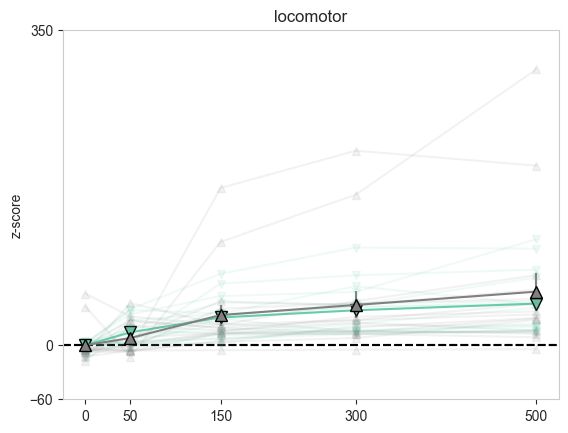

In [92]:
fig,ax = plt.subplots()

for su in female_der_locom['sub'].unique():
    fem_temp_sub = female_der_locom[female_der_locom['sub']==su]
    ax.errorbar( fem_temp_sub['intensity'], fem_temp_sub['locomotor'], color='#66CDAA', marker='v', markerfacecolor='#66CDAA', linestyle='-',markeredgecolor=None, alpha=.1 )
der_psize_curve_avg = female_der_locom.groupby('intensity',axis=0).mean().reset_index()
der_psize_curve_sem = female_der_locom.groupby('intensity',axis=0).sem().reset_index()
ax.errorbar( der_psize_curve_avg['intensity'], der_psize_curve_avg['locomotor'], yerr=der_psize_curve_sem['locomotor'], color='#66CDAA', marker='v', markerfacecolor='#66CDAA', linestyle='-',markeredgecolor='k', alpha=1, markersize=8 )
ax.axhline(y=0, color='k',linestyle='--')
ax.set_ylabel('z-score')
ax.set_title('locomotor')
#ax_pup_peaks.set_xlabel('Shock Intensity Level [uA]')
ax.grid(False)
ax.set_xticks(intensities_real)
#ax.set_xticklabels([])
ax.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
ax.set_yticks([ylims['locom'][0],0,ylims['locom'][1]])


for su in male_der_locom['sub'].unique():
    mal_temp_sub = male_der_locom[male_der_locom['sub']==su]
    ax.errorbar( mal_temp_sub['intensity'], mal_temp_sub['locomotor'], color='grey', marker='^', markerfacecolor='grey', linestyle='-',markeredgecolor=None, alpha=.1 )
der_psize_curve_avg = male_der_locom.groupby('intensity',axis=0).mean().reset_index()
der_psize_curve_sem = male_der_locom.groupby('intensity',axis=0).sem().reset_index()
ax.errorbar( der_psize_curve_avg['intensity'], der_psize_curve_avg['locomotor'], yerr=der_psize_curve_sem['locomotor'], color='grey', marker='^', markerfacecolor='grey', linestyle='-',markeredgecolor='k', alpha=1, markersize=8 )
ax.axhline(y=0, color='k',linestyle='--')
ax.set_ylabel('z-score')
ax.set_title('locomotor')
#ax_pup_peaks.set_xlabel('Shock Intensity Level [uA]')
ax.grid(False)
ax.set_xticks(intensities_real)
#ax.set_xticklabels([])
ax.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
ax.set_yticks([ylims['locom'][0],0,ylims['locom'][1]])



In [93]:
der_locom['unique_id'] = der_locom['sub'].apply(str)+ '_' + der_locom['sex']
pg.mixed_anova(data=der_locom,dv='locomotor',within='intensity',between='sex',subject='unique_id').round(3)

C:\Users\pupil\.conda\envs\brain_\lib\site-packages\pingouin\parametric.py:1574: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,sex,381.114,1,30,381.114,0.088,0.769,NaN,0.003,NaN,NaN,NaN,NaN
1,intensity,60350.070,4,120,15087.517,17.589,0.000,0.0,0.370,0.368,False,0.017,0.0
2,Interaction,1668.712,4,120,417.178,0.486,0.746,NaN,0.016,NaN,NaN,NaN,NaN


# Fig S1C

In [94]:
ver_pupil = pd.read_excel('Data/fig_S1/VER_pupil_sex.xlsx')
male_ver_pupil = ver_pupil[ver_pupil['sex']=='male']
female_ver_pupil = ver_pupil[ver_pupil['sex']=='female']

female_ver_pupil

,sub,intensity,pupil,sex
80,0,0,0.245776,female
81,0,50,0.073200,female
82,0,150,2.859699,female
83,0,300,4.804847,female
84,0,500,3.610514,female
...,...,...,...,...
155,15,0,-0.367710,female
156,15,50,0.624863,female
157,15,150,1.767054,female
158,15,300,3.158796,female


C:\Users\pupil\AppData\Local\Temp\ipykernel_13576\2434865025.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ver_psize_curve_avg = female_ver_pupil.groupby('intensity',axis=0).mean().reset_index()
C:\Users\pupil\AppData\Local\Temp\ipykernel_13576\2434865025.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ver_psize_curve_sem = female_ver_pupil.groupby('intensity',axis=0).sem().reset_index()
C:\Users\pupil\AppData\Local\Temp\ipykernel_13576\2434865025.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. 

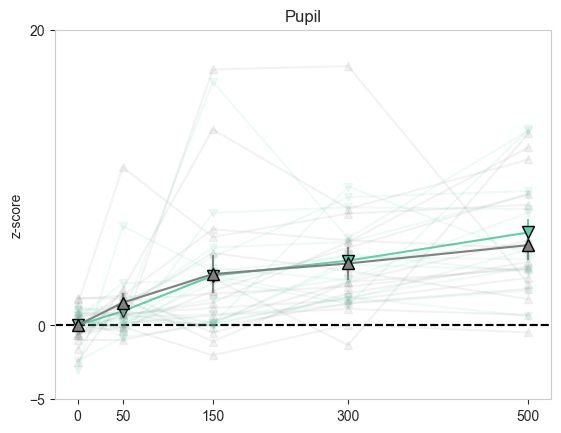

In [95]:
fig,ax = plt.subplots()

for su in female_ver_pupil['sub'].unique():
    fem_temp_sub = female_ver_pupil[female_ver_pupil['sub']==su]
    ax.errorbar( fem_temp_sub['intensity'], fem_temp_sub['pupil'], color='#66CDAA', marker='v', markerfacecolor='#66CDAA', linestyle='-',markeredgecolor=None, alpha=.1 )
ver_psize_curve_avg = female_ver_pupil.groupby('intensity',axis=0).mean().reset_index()
ver_psize_curve_sem = female_ver_pupil.groupby('intensity',axis=0).sem().reset_index()
ax.errorbar( ver_psize_curve_avg['intensity'], ver_psize_curve_avg['pupil'], yerr=ver_psize_curve_sem['pupil'], color='#66CDAA', marker='v', markerfacecolor='#66CDAA', linestyle='-',markeredgecolor='k', alpha=1, markersize=8 )
ax.axhline(y=0, color='k',linestyle='--')
ax.set_ylabel('z-score')
ax.set_title('Pupil')
#ax_pup_peaks.set_xlabel('Shock Intensity Level [uA]')
ax.grid(False)
ax.set_xticks(intensities_real)
#ax.set_xticklabels([])
ax.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
ax.set_yticks([ylims['pupil'][0],0,ylims['pupil'][1]])


for su in male_ver_pupil['sub'].unique():
    mal_temp_sub = male_ver_pupil[male_ver_pupil['sub']==su]
    ax.errorbar( mal_temp_sub['intensity'], mal_temp_sub['pupil'], color='grey', marker='^', markerfacecolor='grey', linestyle='-',markeredgecolor=None, alpha=.1 )
ver_psize_curve_avg = male_ver_pupil.groupby('intensity',axis=0).mean().reset_index()
ver_psize_curve_sem = male_ver_pupil.groupby('intensity',axis=0).sem().reset_index()
ax.errorbar( ver_psize_curve_avg['intensity'], ver_psize_curve_avg['pupil'], yerr=ver_psize_curve_sem['pupil'], color='grey', marker='^', markerfacecolor='grey', linestyle='-',markeredgecolor='k', alpha=1, markersize=8 )
ax.axhline(y=0, color='k',linestyle='--')
ax.set_ylabel('z-score')
ax.set_title('Pupil')
#ax_pup_peaks.set_xlabel('Shock Intensity Level [uA]')
ax.grid(False)
ax.set_xticks(intensities_real)
#ax.set_xticklabels([])
ax.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
ax.set_yticks([-5,0,20])

In [96]:
ver_pupil['unique_id'] = ver_pupil['sub'].apply(str)+ '_' + der_locom['sex']
pg.mixed_anova(data=ver_pupil,dv='pupil',within='intensity',between='sex',subject='unique_id').round(3)

C:\Users\pupil\.conda\envs\brain_\lib\site-packages\pingouin\parametric.py:1574: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,sex,0.207,1,30,0.207,0.010,0.921,NaN,0.000,NaN,NaN,NaN,NaN
1,intensity,705.402,4,120,176.350,19.780,0.000,0.0,0.397,0.728,False,0.413,0.002
2,Interaction,8.692,4,120,2.173,0.244,0.913,NaN,0.008,NaN,NaN,NaN,NaN


## Fig S1D

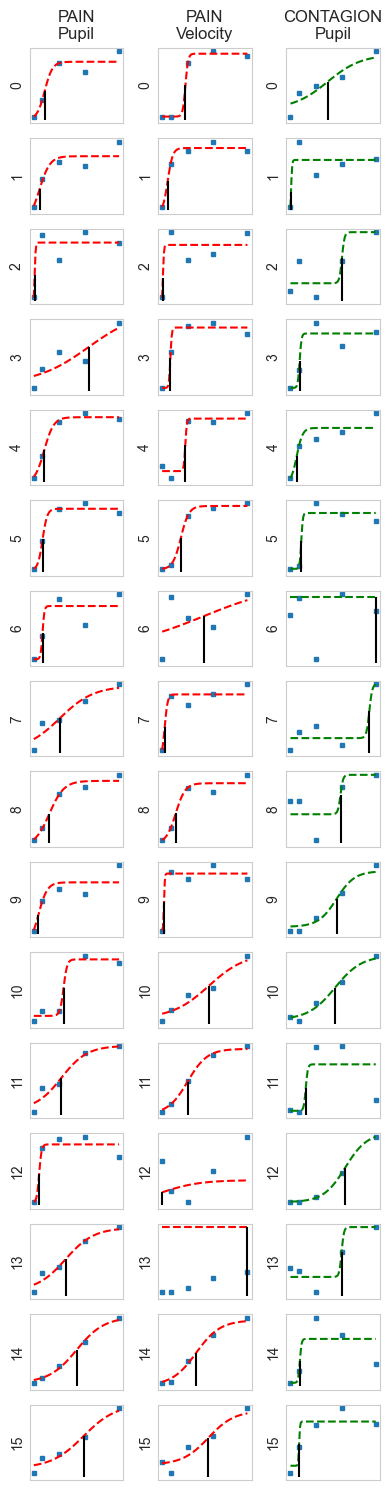

In [110]:

mal_fit_res = list()
subs = male_der_pupil['sub'].unique()
fig,ax = plt.subplots(subs.shape[0],3,figsize=(4,15),sharex=False)
for i,s in enumerate(subs):
    y_values = male_der_pupil[male_der_pupil['sub']==s]['pupil'].values
    y_values = y_values/np.max(y_values)
    mal_psych_der_pupil = PsychometricFit()
    mal_psych_der_pupil.fit(intensities_real_norm,y_values)
    x_pred = np.linspace(0,max(intensities_real_norm),100)
    y_pred = mal_psych_der_pupil.predict(x_pred)
    ax[i,0].plot(intensities_real_norm, y_values,'s', markersize=3)
    ax[i,0].plot(x_pred, y_pred, color='r',linestyle='--')
    lims = ax[i,0].get_ylim()
    ax[i,0].vlines(mal_psych_der_pupil.threshold,color='k',linestyle='-', ymax=mal_psych_der_pupil.predict(mal_psych_der_pupil.threshold), ymin=lims[0])
    ax[i,0].grid(False)
    ax[i,0].set_ylabel( i)
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])


    y_values = male_der_locom[male_der_locom['sub']==s]['locomotor'].values
    y_values = y_values/np.max(y_values-y_values[0])
    mal_psych_der_locom = PsychometricFit()
    mal_psych_der_locom.fit(intensities_real_norm,y_values)
    x_pred = np.linspace(0,max(intensities_real_norm),100)
    y_pred = mal_psych_der_locom.predict(x_pred)
    ax[i,1].plot(intensities_real_norm, y_values,'s', markersize=3)
    ax[i,1].plot(x_pred, y_pred, color='r',linestyle='--')
    lims = ax[i,1].get_ylim()
    ax[i,1].vlines(mal_psych_der_locom.threshold,color='k',linestyle='-', ymax=mal_psych_der_locom.predict(mal_psych_der_locom.threshold), ymin=lims[0])
    ax[i,1].grid(False)
    ax[i,1].set_ylabel( i)
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])


    y_values = male_ver_pupil[male_ver_pupil['sub']==s]['pupil'].values
    y_values = y_values/np.max(y_values)
    mal_psych_ver_pupil = PsychometricFit()
    mal_psych_ver_pupil.fit(intensities_real_norm,y_values)
    x_pred = np.linspace(0,max(intensities_real_norm),100)
    y_pred = mal_psych_ver_pupil.predict(x_pred)
    ax[i,2].plot(intensities_real_norm, y_values,'s', markersize=3)
    ax[i,2].plot(x_pred, y_pred, color='g',linestyle='--')
    lims = ax[i,2].get_ylim()
    ax[i,2].vlines(mal_psych_ver_pupil.threshold,color='k',linestyle='-', ymax=mal_psych_ver_pupil.predict(mal_psych_ver_pupil.threshold), ymin=lims[0])
    ax[i,2].grid(False)
    ax[i,2].set_ylabel( i)
    ax[i,2].set_xticks([])
    ax[i,2].set_yticks([])

    if i==0:
        ax[i,0].set_title('PAIN\nPupil')
        ax[i,1].set_title('PAIN\nVelocity')
        ax[i,2].set_title('CONTAGION\nPupil')

    temp = pd.concat([mal_psych_der_pupil.summary_dataframe().add_prefix('pp_'),
                      mal_psych_der_locom.summary_dataframe().add_prefix('pv_'),
                      mal_psych_ver_pupil.summary_dataframe().add_prefix('ep_')],axis=1)
    temp.index=[i]
    mal_fit_res.append(temp)

plt.tight_layout()

mal_fit_res = pd.concat(mal_fit_res)
mal_fit_res = mal_fit_res.reset_index().rename(columns={'index':'sub'})
#rev_sub = {v:k for k,v in mal_pain_sub_folder.items()}
#mal_fit_res.insert(0,'sub',[rev_sub[i] for i in mal_fit_res.index])

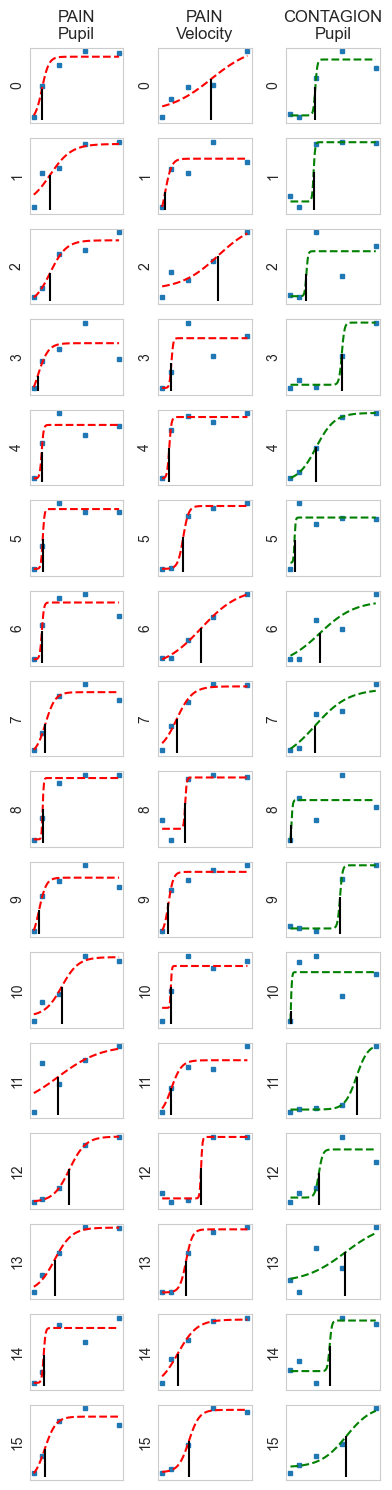

In [111]:

fem_fit_res = list()
subs = female_der_pupil['sub'].unique()
fig,ax = plt.subplots(subs.shape[0],3,figsize=(4,15),sharex=False)
for i,s in enumerate(subs):
    y_values = female_der_pupil[female_der_pupil['sub']==s]['pupil'].values
    y_values = y_values/np.max(y_values)
    fem_psych_der_pupil = PsychometricFit()
    fem_psych_der_pupil.fit(intensities_real_norm,y_values)
    x_pred = np.linspace(0,max(intensities_real_norm),100)
    y_pred = fem_psych_der_pupil.predict(x_pred)
    ax[i,0].plot(intensities_real_norm, y_values,'s', markersize=3)
    ax[i,0].plot(x_pred, y_pred, color='r',linestyle='--')
    lims = ax[i,0].get_ylim()
    ax[i,0].vlines(fem_psych_der_pupil.threshold,color='k',linestyle='-', ymax=fem_psych_der_pupil.predict(fem_psych_der_pupil.threshold), ymin=lims[0])
    ax[i,0].grid(False)
    ax[i,0].set_ylabel( i)
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])


    y_values = female_der_locom[female_der_locom['sub']==s]['locomotor'].values
    y_values = y_values/np.max(y_values)
    fem_psych_der_locom = PsychometricFit()
    fem_psych_der_locom.fit(intensities_real_norm,y_values)
    x_pred = np.linspace(0,max(intensities_real_norm),100)
    y_pred = fem_psych_der_locom.predict(x_pred)
    ax[i,1].plot(intensities_real_norm, y_values,'s', markersize=3)
    ax[i,1].plot(x_pred, y_pred, color='r',linestyle='--')
    lims = ax[i,1].get_ylim()
    ax[i,1].vlines(fem_psych_der_locom.threshold,color='k',linestyle='-', ymax=fem_psych_der_locom.predict(fem_psych_der_locom.threshold), ymin=lims[0])
    ax[i,1].grid(False)
    ax[i,1].set_ylabel( i)
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])


    y_values = female_ver_pupil[female_ver_pupil['sub']==s]['pupil'].values
    y_values = y_values/np.max(y_values)
    fem_psych_ver_pupil = PsychometricFit()
    fem_psych_ver_pupil.fit(intensities_real_norm,y_values)
    x_pred = np.linspace(0,max(intensities_real_norm),100)
    y_pred = fem_psych_ver_pupil.predict(x_pred)
    ax[i,2].plot(intensities_real_norm, y_values,'s', markersize=3)
    ax[i,2].plot(x_pred, y_pred, color='g',linestyle='--')
    lims = ax[i,2].get_ylim()
    ax[i,2].vlines(fem_psych_ver_pupil.threshold,color='k',linestyle='-', ymax=fem_psych_ver_pupil.predict(fem_psych_ver_pupil.threshold), ymin=lims[0])
    ax[i,2].grid(False)
    ax[i,2].set_ylabel( i)
    ax[i,2].set_xticks([])
    ax[i,2].set_yticks([])

    if i==0:
        ax[i,0].set_title('PAIN\nPupil')
        ax[i,1].set_title('PAIN\nVelocity')
        ax[i,2].set_title('CONTAGION\nPupil')

    temp = pd.concat([fem_psych_der_pupil.summary_dataframe().add_prefix('pp_'),
                      fem_psych_der_locom.summary_dataframe().add_prefix('pv_'),
                      fem_psych_ver_pupil.summary_dataframe().add_prefix('ep_')],axis=1)
    temp.index=[i]
    fem_fit_res.append(temp)

plt.tight_layout()

fem_fit_res = pd.concat(fem_fit_res)
fem_fit_res = fem_fit_res.reset_index().rename(columns={'index':'sub'})


C:\Users\pupil\AppData\Local\Temp\ipykernel_13576\777835842.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=pp_thresh,x='sex',y='pp_threshold',alpha=.2,palette=['gray','#66CDAA'],ax=ax)
C:\Users\pupil\AppData\Local\Temp\ipykernel_13576\777835842.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data=pp_thresh,x='sex',y='pp_threshold',linestyle='none',palette=['gray','#66CDAA'],ax=ax,capsize=0.05)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.404527,30,two-sided,0.170431,"[-0.04, 0.2]",0.496575,0.709,0.274628


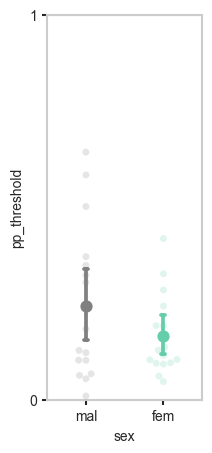

In [125]:
maltemp = mal_fit_res[['sub','pp_threshold']].copy()
maltemp['sex'] = 'mal'
femtemp = fem_fit_res[['sub','pp_threshold']].copy()
femtemp['sex'] = 'fem'
pp_thresh = pd.concat([maltemp,femtemp])


fig,ax = plt.subplots(figsize=(2,5))
sns.swarmplot(data=pp_thresh,x='sex',y='pp_threshold',alpha=.2,palette=['gray','#66CDAA'],ax=ax)
sns.pointplot(data=pp_thresh,x='sex',y='pp_threshold',linestyle='none',palette=['gray','#66CDAA'],ax=ax,capsize=0.05)
ax.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
ax.set_ylim([0,1])
ax.set_yticks([0,1])

#plt.savefig('der_pupil_fit.png')
sts = pg.ttest(mal_fit_res['pp_threshold'],fem_fit_res['pp_threshold'])
sts

C:\Users\pupil\AppData\Local\Temp\ipykernel_13576\2213734643.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=pp_thresh,x='sex',y='pv_threshold',alpha=.2,palette=['gray','#66CDAA'],ax=ax)
C:\Users\pupil\AppData\Local\Temp\ipykernel_13576\2213734643.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data=pp_thresh,x='sex',y='pv_threshold',linestyle='none',palette=['gray','#66CDAA'],ax=ax,capsize=0.05)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.223428,30,two-sided,0.824717,"[-0.15, 0.19]",0.078994,0.343,0.05538


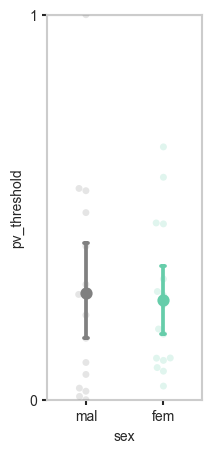

In [126]:
maltemp = mal_fit_res[['sub','pv_threshold']].copy()
maltemp['sex'] = 'mal'
femtemp = fem_fit_res[['sub','pv_threshold']].copy()
femtemp['sex'] = 'fem'
pp_thresh = pd.concat([maltemp,femtemp])


fig,ax = plt.subplots(figsize=(2,5))
sns.swarmplot(data=pp_thresh,x='sex',y='pv_threshold',alpha=.2,palette=['gray','#66CDAA'],ax=ax)
sns.pointplot(data=pp_thresh,x='sex',y='pv_threshold',linestyle='none',palette=['gray','#66CDAA'],ax=ax,capsize=0.05)
ax.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
ax.set_ylim([0,1])

ax.set_ylim([0,1])
ax.set_yticks([0,1])

#plt.savefig('der_locom_fit.png')
sts = pg.ttest(mal_fit_res['pv_threshold'],fem_fit_res['pv_threshold'])
sts

C:\Users\pupil\AppData\Local\Temp\ipykernel_13576\347927816.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=pp_thresh,x='sex',y='ep_threshold',alpha=.2,palette=['gray','#66CDAA'],ax=ax)
C:\Users\pupil\AppData\Local\Temp\ipykernel_13576\347927816.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data=pp_thresh,x='sex',y='ep_threshold',linestyle='none',palette=['gray','#66CDAA'],ax=ax,capsize=0.05)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.486605,30,two-sided,0.630075,"[-0.15, 0.25]",0.172041,0.368,0.075801


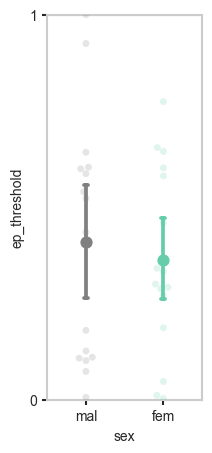

In [127]:
maltemp = mal_fit_res[['sub','ep_threshold']].copy()
maltemp['sex'] = 'mal'
femtemp = fem_fit_res[['sub','ep_threshold']].copy()
femtemp['sex'] = 'fem'
pp_thresh = pd.concat([maltemp,femtemp])


fig,ax = plt.subplots(figsize=(2,5))
sns.swarmplot(data=pp_thresh,x='sex',y='ep_threshold',alpha=.2,palette=['gray','#66CDAA'],ax=ax)
sns.pointplot(data=pp_thresh,x='sex',y='ep_threshold',linestyle='none',palette=['gray','#66CDAA'],ax=ax,capsize=0.05)
ax.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
ax.set_ylim([0,1])
ax.set_ylim([0,1])
ax.set_yticks([0,1])

#plt.savefig('ver_pupil_fit.png')
sts = pg.ttest(mal_fit_res['ep_threshold'],fem_fit_res['ep_threshold'])
sts.to_excel('temp.xlsx')
sts